# Build an autonomous multi-agents workflow to write picture book

# Part 1
- **Goal**: Write a outline for a story

## 1. Install dependecies

In [2]:
%pip install -q langchain_community==0.0.32 langgraph==0.0.51 langchain-aws==0.1.6 pygraphviz==1.13

Note: you may need to restart the kernel to use updated packages.


## 2. Some Utils functions

### 2.1 Structrued Output parser
- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [102]:
import os
import json
import re
from langchain_core.output_parsers.base import BaseOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from json import JSONDecodeError


def dict_to_obj(json_str:dict, target:object):
    return target.parse_obj(json_str)

class CustJsonOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
        else:
            return {}    
        new_dict = json.loads(text.replace('\n','  '))
        
        return new_dict

    @property
    def _type(self) -> str:
        return "cust_output_parser"

class TextOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            return text.strip()
        else:
            return ''

    @property
    def _type(self) -> str:
        return "TextOuputParser"

- prompt facilitate to json output

In [25]:
fc_desc = """
You will ALWAYS follow the below guidelines when you are answering a question:
<guidelines>
- Think through the user's question, extract all data from the question and the previous conversations before creating a plan.
- Always output your thoughts within <thinking></thinking> xml tags before you respond to the user. 
- Your response must be follow the pydantic schema as:
<schema>
{schema}
</shema>
- output your answer in json format, enclosed in tag <answer>, so that the user can use pydantic basemodel.parse_obj() to parse the json string into an object which defined as:
 <schema>
 {schema}
 </shema>
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
</guidelines>
"""

### 2.2 LLM models

In [94]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                )

llm_haiku = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

## 3 Agent Roles settings

- In this step, we will create two agents "cartoonist" and "screenwriter", to create an outline.
- The cartoonist create an initial draft, and then ask screenwriter to create the characters. Then cartoonist will revise the outline draft by incooperating the characters.

In [16]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [17]:
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio.
      """,
      
"screenwriter":  
      company_setting+"""You are a Screenwriter.
Your task is to create a main character and a diverse and distinct group of supporting characters for a new story, based on the provided topic and outline.
For each supporting character, please provide the following:
1. A unique name and role in the story (e.g. sidekick, mentor, rival, etc.)
2. A brief description of their perspective, affiliation, or background related to the story's themes
3. An explanation of what aspects of the story they will focus on or influence
Additionally, think step-by-step about how to make this group of characters distinct and complementary to create an engaging, multifaceted narrative
""",
}

## 4.Create Prompts template and Chains

### 4.1 Create a Outline class to format the LLM output

In [23]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

class Chapter(BaseModel):
    chapter_title: str = Field(..., title="Title of the chapter")
    description: str = Field(..., title="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        min_items=8,
        # max_items=20,
        title="Titles and descriptions for each chapter of the comics book.",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()


- prompt template

In [36]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config["cartoonist"]+ fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

### 4.2 Give a story topic  

In [27]:
topic = "A little boy who lived in a mountain village obtained a magic book in the wild. He became self-taught and became the most powerful magician in the world, helping the world resist alien invasions. "


In [33]:
# define a chain
generate_outline_direct = direct_gen_outline_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)

- test for generation
- If you encounter JSONDecodeError, please rerun again

In [32]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}")],"schema":Outline.schema_json() })

<thinking>
Based on the topic provided, here are the key points I need to cover in the outline for a comics book:

- Introduce the little boy character living in a mountain village
- Describe how he obtained a magic book in the wild 
- Show how he taught himself magic from the book and became very powerful
- Depict his journey to becoming the most powerful magician in the world
- Explain the alien invasion threat to the world
- Illustrate how the boy, now a powerful magician, helps resist the alien invasion and saves the world

With those key points in mind, I will structure the outline into multiple chapters covering the character's journey and ultimate battle against the alien invasion.
</thinking>

<answer>
{
  "page_title": "The Magic Book and the Alien Invasion",
  "chapters": [
    {
      "chapter_title": "The Mountain Village Boy",
      "description": "Introduce the young boy living a simple life in a remote mountain village."
    },
    {
      "chapter_title": "Discovery in 

In [43]:
print(outline.as_str)

# The Magic Book and the Alien Invasion

## The Mountain Village Boy

Introduce the young boy living a simple life in a remote mountain village.

## Discovery in the Wild

The boy finds a mysterious ancient book of magic while exploring the wilderness around his village.

## Self-Taught Sorcery

Alone, the boy studies and practices the magic from the book, mastering powerful spells.

## The Prodigious Prodigy

Through relentless training, the boy becomes a prodigiously skilled young magician.

## The Alien Threat Emerges

Strange alien ships appear in the skies, harbingers of an imminent extraterrestrial invasion.

## A Lone Beacon of Hope

The world's leaders realize the boy is the only one powerful enough to combat the alien invasion.

## The Sorcerer Supreme

The young magician is declared the world's Sorcerer Supreme and leads the defense against the aliens.

## The Final Cosmic Battle

In an epic magical confrontation, the Sorcerer Supreme faces the alien invasion force to decide 

### 4.3 Create characters

- Create a Character class to format the LLM output
- You can change the number of supporting characters

In [35]:
class Persona(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the character.",
    )
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story.",
    )
    description: str = Field(
        description="description of the character’s personality, hobbies, etc.",
    )
    figure: str = Field(
        description="figure representing such as a boy,a girl,a man, a women, a young woman,an old man or etc",
    )
    appearance: str = Field(
        description="appearance, attire of the character in the story.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nBackground: {self.background}\nDescription: {self.description}\nFigure:{self.figure}\nAppearance: {self.appearance}\n"
    
class Character(BaseModel):
    main_character: Persona = Field(
        description="the main character in the story.",
    )
    
    supporting_character: List[Persona] = Field(
        description="Comprehensive list of supporting characters in the story.",
        min_items=1,
        max_items=3,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.supporting_character])+'\n'+self.main_character.persona

- prompt template 

In [41]:
gen_character_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
           role_config["screenwriter"]+ fc_desc,
        ),
         MessagesPlaceholder(variable_name="messages")
    ]
)
gen_characters_chain = gen_character_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)

- test for generation

In [42]:
request = HumanMessage(content=f"Here is the outline:{outline.json()}")
characters = gen_characters_chain.invoke({"messages": [request],"schema":Character.schema_json()})

<thinking>
Based on the provided outline for "The Magic Book and the Alien Invasion" story, the main character will be a young boy from a remote mountain village who discovers an ancient magic book and becomes a powerful sorcerer. He will then have to use his newfound abilities to defend Earth against an alien invasion.

For the supporting characters, I will create:

1. A wise old mentor figure to guide the boy in learning magic initially
2. A skeptical village leader who doubts the boy's powers at first but comes to respect him
3. A female alien commander leading the invasion who serves as the main antagonist

These supporting characters will help develop different aspects of the story:

- The mentor will teach the boy about magic and its responsibilities, representing wisdom and guidance.
- The village leader's skepticism will create conflict and obstacles for the boy to overcome through perseverance.
- The alien commander will drive the invasion plot and serve as the central threat/

In [44]:
print(characters.as_str)

Name: Ezra
Role: Mentor
Affiliation: Mountain Village
Background: Ezra is an ancient and wise sorcerer who has lived in seclusion deep in the mountains for centuries, guarding the magic book. When Kai finds the book, Ezra senses his potential and emerges from hiding to guide and mentor the young prodigy in the ways of magic.
Description: Ezra is a stoic and enigmatic figure, his face lined with the wisdom of ages. Though he speaks infrequently, his words carry great weight and insight. Despite his immense power, Ezra believes in allowing Kai to discover his own path, offering gentle guidance and lessons when needed.
Figure:an old man
Appearance: Ezra is an elderly man with a long, unkempt silver beard and piercing blue eyes. He wears tattered robes and a weathered cloak, carrying a gnarled wooden staff etched with arcane symbols.

Name: Greta
Role: Village Leader
Affiliation: Mountain Village
Background: Greta is the respected elder and leader of Kai's mountain village. Initially skept

### 4.4 Add charaters to refine outline

- test for refine generation

In [46]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}"),
                                                               AIMessage(content=f"Here is the outline draft:{outline.json()}, "),
                                                               HumanMessage(content=f"Here is the characters description:{characters.json()}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific ")],
                                          "schema":Outline.schema_json() })

<thinking>
Based on the provided character descriptions, I will update the outline draft to incorporate the key characters and their roles in the story:

- Kai will be the main protagonist, a young boy from a mountain village who discovers the magic book and becomes a powerful sorcerer to defend against the alien invasion.
- Ezra will be introduced as Kai's mentor, an ancient sorcerer who guides Kai in learning magic from the book.
- Greta will be the village leader who is initially skeptical of Kai's magic but comes to support him as the Sorcerer Supreme against the alien threat.
- Zelara will be the main antagonist, the commander of the alien invasion force seeking to conquer Earth and subjugate humanity.

I will expand the chapter descriptions to weave in these characters and their roles, while maintaining the overall story arc of Kai's journey from a village boy to the world's greatest sorcerer defending against the alien invasion.
</thinking>

<answer>
{
  "page_title": "The Magic

In [47]:
print(outline.as_str)

# The Magic Book and the Alien Invasion

## The Mountain Village Boy

Introduce Kai, a young boy living a simple life in a remote mountain village under the leadership of Greta, the respected village elder.

## The Ancient Sorcerer's Tome

While exploring the wilderness, Kai stumbles upon an ancient book of magic, guarded by the reclusive sorcerer Ezra for centuries.

## Ezra's Apprentice

Sensing Kai's potential, Ezra emerges from hiding to mentor the boy in the ways of magic, guiding his studies of the ancient tome.

## The Prodigious Prodigy

Through relentless training under Ezra's tutelage, Kai masters powerful spells and becomes a prodigiously skilled young magician, much to Greta's initial skepticism.

## The Alien Invasion Begins

Strange alien ships commanded by the merciless Zelara appear in the skies, harbingers of an imminent extraterrestrial invasion to subjugate Earth.

## The Sorcerer Supreme

As the alien threat grows, Greta recognizes Kai as the world's only hope and r

## 5 build outline workflow graph

#### Create LangGraph state

In [48]:
from langgraph.graph import StateGraph, END
import operator
from typing import Annotated, Sequence,Dict,Optional,Any,TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]

#### Create claude message format function

In [95]:
def convert_message_name(message:BaseMessage):
    if isinstance(message, AIMessage) and message.name:
        return AIMessage(content=f"{message.name} : {message.content}")
    elif isinstance(message, HumanMessage) and message.name:
        return HumanMessage(content=f"{message.name} : {message.content}")
    else:
        return message

##merge the continouse roles, and change sequences 
def reconstruct_to_claude_messages(messages):
    rec_messages = []
    for message in messages:
        message = convert_message_name(message)
        if rec_messages:
            if isinstance(rec_messages[0], AIMessage):
                rec_messages[0] = HumanMessage(content=rec_messages[0].content)
            last_msg = rec_messages[-1]
            last_role = 'assistant' if isinstance(last_msg,AIMessage) else 'user'
            current_role = 'assistant' if isinstance(message,AIMessage) else 'user'
            if last_role == current_role:
                last_msg_content = last_msg.content[-1]['text'] if isinstance(last_msg.content,list) else last_msg.content
                current_msg_content = message.content[-1]['text'] if isinstance(message.content, list) else message.content
                new_content = last_msg_content +"\n\n" + current_msg_content
                rec_messages[-1] = HumanMessage(content=new_content) if last_role == 'user' else AIMessage(content=new_content)
            else:
                rec_messages.append(message)
        else:
            rec_messages.append(message)
    return rec_messages

def swap_roles(messages, name: str):
    converted = []
    for message in messages:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return  converted

#### Retry mechanism to ensure the success rate of final json output 

In [124]:
from langchain_core.pydantic_v1 import ValidationError

async def retry_call(chain,args: Dict[str,Any],times:int=5):
    try:
        content = await chain.ainvoke(args)
        return content
    except JSONDecodeError as e:
        if times:
            print(f'JSONDecodeError, retry again [{times}]')
            return await retry_call(chain,args,times=times-1)
        else:
            raise(JSONDecodeError(e))
    except ValidationError as e:
        print(e)
        if times:
            print(f'ValidationError, retry again [{times}]')
            return await retry_call(chain,args,times=times-1)
        else:
            raise(ValidationError(e))

#### Define node

In [126]:
async def generate_outline(state:AgentState):
    """
    Generate outline

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_outline---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    generate_outline_chain = direct_gen_outline_prompt | llm_haiku | CustJsonOuputParser(verbose=False) | RunnableLambda(dict_to_obj).bind(target=Outline)
    name = "cartoonist"
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(messages)
    outline = await retry_call(generate_outline_chain,{"messages": messages,"schema":Outline.schema_json() })
    response = AIMessage(content=f"Here is the outline: \n{outline.json()}",name=name)
    return {"messages":[response],"env_var":{**env_var,"outline":outline}}

async def generate_characters(state:AgentState):
    """
    Generate characters

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_characters---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    name = 'screenwriter'
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(state['messages'])
    gen_characters_chain = gen_character_prompt | llm_sonnet | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=Character)
    characters = await retry_call(gen_characters_chain,{"messages": messages,"schema":Character.schema_json() })
    print("characters",characters)
    response = AIMessage(content=f"Here is the characters description:\n{characters.json()}.\n Your task is to rewrite the outline draft for a story based on the outline draft. Please incorporate all the characters in the story, and keep the outline be comprehensive and specific ",name=name)

    return {"messages":[response],"env_var":{**env_var,"characters":characters}}

#### add conditional edge

In [127]:
MAX_TURNS = 3
def should_repeat_outline(state: AgentState):
    messages = state['messages']
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print('messages:',num_responses)
    if num_responses > MAX_TURNS:
        return 'end'
    else:
        return 'generate_characters'

#### build workflow

In [128]:
outline_graph = StateGraph(AgentState)
outline_graph.add_node("generate_outline",generate_outline)
outline_graph.add_node("generate_characters",generate_characters)
outline_graph.set_entry_point("generate_outline")
outline_graph.add_edge("generate_characters", "generate_outline")
outline_graph.add_conditional_edges("generate_outline",
                                   should_repeat_outline,
                                   {
                                       'end':END,
                                       'generate_characters':'generate_characters'
                                   }
                                   )
outline_workflow = outline_graph.compile()

#### print out the graph

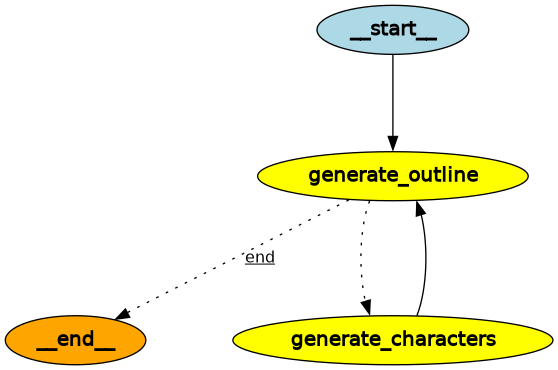

In [129]:
from IPython.display import Image

Image(outline_workflow.get_graph().draw_png())

- test generation

In [130]:
steps = []
init_state = {
    "env_var":{"topic":topic},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}
async for event in outline_workflow.astream(init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---generate_outline---
messages: 1
Output from node 'generate_outline':
---
{'messages': [AIMessage(content='Here is the outline: \n{"page_title": "The Magician\'s Apprentice", "chapters": [{"chapter_title": "The Mountain Village", "description": "Introduces the young protagonist, a curious and imaginative boy living in a remote mountain village. He spends his days exploring the nearby forests and daydreaming about magic and adventure."}, {"chapter_title": "The Discovery of the Magic Book", "description": "While wandering in the woods, the boy stumbles upon an ancient, weathered book hidden in the hollow of a tree. He takes it back to his home, and upon opening it, discovers that it contains powerful spells and incantations."}, {"chapter_title": "The Self-Taught Magician", "description": "Fascinated by the book\'s contents, the boy begins to study and practice the magic rituals, teaching himself the arcane arts. As he masters the spells, he realizes the true extent of the book\'s power

#### retrieve outline and characters objects from the final step

In [136]:
outline = steps[-1]['generate_outline']['env_var']['outline']

In [137]:
characters = steps[-1]['generate_outline']['env_var']['characters']

In [141]:
print(outline.as_str)

# The Magician's Apprentice

## The Mountain Village

The story opens in the remote mountain village where Ari, a curious and imaginative young boy, lives with his childhood friend Mira. Ari spends his days exploring the nearby forests, dreaming of adventure and magic, while Mira, a kind and loyal young woman, supports and believes in him. The villagers lead a simple, peaceful life, unaware of the looming threat on the horizon. Ari's thirst for knowledge and his fascination with the natural world set him apart from the other villagers, who view his interests as peculiar.

## The Discovery of the Magic Book

One day, while venturing deeper into the woods, Ari stumbles upon an ancient, weathered book hidden in the hollow of a tree. Intrigued, he takes the book back to his home and begins to study its contents. As he delves into the pages, he discovers that the book contains powerful spells and incantations, unlocking a world of magic that he never knew existed. Mira, curious about Ari's 

In [140]:
print(characters.as_str)

Name: Zarina
Role: Mentor
Affiliation: City of Mages
Background: A wise and experienced magician from the City of Mages, who takes Ari under her wing and guides his magical training.
Description: Zarina is a powerful and enigmatic mage, with a deep understanding of the arcane arts. She is patient and nurturing, yet firm in her teachings, pushing Ari to reach his full potential. Beneath her calm exterior lies a fierce determination to protect the world from the looming alien threat.
Figure:an old woman
Appearance: Zarina has long, silver hair and piercing blue eyes. She wears flowing robes adorned with intricate magical symbols, and carries a gnarled staff imbued with ancient power.

Name: Kravath
Role: Antagonist
Affiliation: Alien Invaders
Background: The ruthless leader of the alien invasion force, seeking to conquer and enslave humanity.
Description: Kravath is a cold, calculating being with an insatiable hunger for power. He views humans as inferior creatures, ripe for subjugation,

#### Save to local files

In [142]:
with open('characters.json','w') as f:
    f.write(characters.json())

In [143]:
with open('outline.json','w') as f:
    f.write(outline.json())